In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import files 
uploaded = files.upload()

Saving imputed features_final.csv to imputed features_final.csv
Saving Optimal_target_with_92_Q3_2점.csv to Optimal_target_with_92_Q3_2점.csv


In [3]:
import io
feature = pd.read_csv(io.BytesIO(uploaded['imputed features_final.csv'])) 
optimal_target = pd.read_csv(io.BytesIO(uploaded['Optimal_target_with_92_Q3_2점.csv'])) 

In [4]:
optimal_target = optimal_target.drop(columns = 'Unnamed: 0')
feature = feature.drop(columns = 'Unnamed: 0')

In [5]:
feature.describe()

,SubjectID,Age,Gender,diag_delta,onset_delta,onset_site,diag_minus_onset,fvc_slope,fvc_mean,mean_alsfrs_total,mean_Q1_Speech,mean_Q2_Salivation,mean_Q3_Swallowing,mean_Q4_Handwriting,mean_Q5_Cutting,mean_Q6_Dressing_and_Hygiene,mean_Q7_Turning_in_Bed,mean_Q8_Walking,mean_Q9_Climbing_Stairs,mean_Q10_Respiratory,mean_Bulbar,mean_motor,slope_alsfrs_tot,slope_Q1_Speech,slope_Q2_Salivation,slope_Q3_Swallowing,slope_Q4_Handwriting,slope_Q5_Cutting,slope_Q6_Dressing_and_Hygiene,slope_Q7_Turning_in_Bed,slope_Q8_Walking,slope_Q9_Climbing_Stairs,slope_Q10_Respiratory,slope_Bulbar,slope_motor
count,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000,4454.000000
mean,502951.987652,55.442748,0.625056,-278.442748,-609.874944,0.199077,331.432196,-0.095553,80.145256,28.758350,3.098164,3.370428,3.416574,2.901893,2.574622,2.411366,2.960302,2.618122,1.856466,3.550132,6.515164,15.322883,-0.027981,-0.002049,-0.001586,-0.001909,-0.002833,-0.003747,-0.004004,0.012036,-0.002505,-0.004210,-0.001919,-0.003955,-0.020522
std,293006.073632,11.686189,0.484163,305.401815,391.917931,0.399466,251.209878,0.345993,21.012072,5.627361,0.993363,0.842266,0.752965,0.995237,1.126275,0.982517,0.914581,0.891939,1.282044,0.596866,1.644885,4.916685,0.069504,0.016784,0.017352,0.014878,0.016931,0.017627,0.016430,0.027147,0.013098,0.021998,0.018432,0.020840,0.053341
min,329.000000,18.000000,0.000000,-7372.000000,-8741.000000,-0.311379,-274.000000,-3.400000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.125000,-0.125000,-0.250506,-0.333333,-0.250000,-0.285714,-0.200000,-0.166667,-0.125000,-0.333333,-0.251044,-0.250000,-0.875000
25%,252186.250000,47.000000,0.000000,-367.000000,-755.000000,0.000000,167.000000,-0.234297,67.750000,25.666667,2.750000,3.000000,3.000000,2.700000,2.000000,2.000000,2.500000,2.000000,1.000000,3.200000,6.000000,12.500000,-0.048387,-0.000500,0.000000,0.000000,-0.001560,-0.011236,-0.011765,0.000000,0.000000,-0.011765,0.000000,-0.006193,-0.036551
50%,509788.500000,56.000000,1.000000,-191.000000,-529.000000,0.000000,273.000000,-0.076210,80.577463,29.000000,3.091153,3.666667,3.666667,3.000000,2.750000,2.426634,3.000000,2.609484,1.818979,3.800000,7.000000,15.419286,-0.024096,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010989,0.000000,0.000000,0.000000,0.000000,-0.016411
75%,760948.750000,64.000000,1.000000,-89.000000,-355.000000,0.000000,421.000000,0.036917,94.000000,33.000000,4.000000,4.000000,4.000000,3.691667,3.500000,3.000000,4.000000,3.000000,3.000000,4.000000,8.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018182,0.000000,0.000000,0.000000,0.000000,0.000000
max,999990.000000,84.000000,1.000000,0.000000,-24.000000,1.000000,2708.000000,8.333333,154.000000,40.000000,4.000000,4.061079,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,8.000000,24.000000,1.666667,0.666667,0.230769,0.153846,0.333333,0.153846,0.285714,0.500000,0.333333,0.500000,0.333333,0.333333,1.000000


In [6]:
feature = feature[['SubjectID','Age', 'Gender', 'onset_site', 'onset_delta',
       'diag_minus_onset', 'slope_alsfrs_tot',
       'fvc_slope', 'fvc_mean',  'mean_Q10_Respiratory',
       'mean_Bulbar', 'mean_motor', 'slope_Q1_Speech', 'slope_Q2_Salivation',
       'slope_Q3_Swallowing', 'slope_Q4_Handwriting', 'slope_Q5_Cutting',
       'slope_Q6_Dressing_and_Hygiene', 'slope_Q7_Turning_in_Bed',
       'slope_Q8_Walking', 'slope_Q9_Climbing_Stairs', 'slope_Q10_Respiratory']]

In [7]:
X_full = pd.merge(feature, optimal_target, on = 'SubjectID')

In [8]:
df_train = X_full.drop(columns='SubjectID')

In [9]:
!pip install lifelines

     |████████████████████████████████| 348 kB 4.8 MB/s 
     |████████████████████████████████| 55 kB 3.2 MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4048 sha256=e38ceb0d4fc892e0c3a8338f13969900eb96b6f530bd2645de1f3ec696c2bf27
  Stored in directory: /root/.cache/pip/wheels/9f/01/ee/1331593abb5725ff7d8c1333aee93a50a1c29d6ddda9665c9f
Successfully built autograd-gamma


##Cox Proportional Hazard model

In [10]:
from lifelines import CoxPHFitter
cph = CoxPHFitter(penalizer=0.01)
cph.fit(df_train, 'time_opt', event_col='status_opt')

<lifelines.CoxPHFitter: fitted with 3399 total observations, 2234 right-censored observations>

In [14]:
cph_median = pd.concat([X_full['SubjectID'],cph.predict_median(df_train)], axis=1)
cph_median

,SubjectID,0.5
0,329.0,inf
1,348.0,946.0
2,708.0,373.0
3,902.0,464.0
4,1736.0,188.0
...,...,...
3394,998756.0,217.0
3395,999166.0,519.0
3396,999823.0,322.0
3397,999880.0,inf


In [24]:
print('There are ' + str(cph_median.replace([np.inf,-np.inf], np.nan).isnull().sum(axis = 0).iloc[1]) + ' inf values in cph_median')

There are 181 inf values


In [35]:
cph_median_max = cph_median.replace([np.inf,-np.inf], np.nan).dropna(subset=[0.5],how='all')[0.5].max()
cph_inf = cph_median_max + 200
cph_median = cph_median.replace([np.inf,-np.inf], cph_inf)

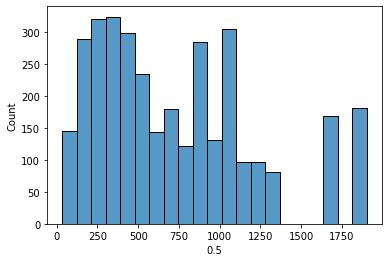

In [37]:
sns.histplot(x = cph_median[0.5])

In [38]:
cph_median.describe()

,SubjectID,0.5
count,3399.000000,3399.000000
mean,506781.466019,730.551927
std,293087.479128,491.176281
min,329.000000,35.000000
25%,253969.500000,338.000000
50%,514072.000000,614.000000
75%,765723.500000,1037.000000
max,999990.000000,1902.000000


In [45]:
cph_slow_list = list(cph_median[cph_median[0.5] >= 1037]['SubjectID'])
cph_medium_list = list(cph_median[(cph_median[0.5] >= 338) & (cph_median[0.5] < 1037)]['SubjectID'])
cph_fast_list = list(cph_median[cph_median[0.5]  < 338]['SubjectID'])
X_cph_slow = X_full[X_full['SubjectID'].isin(cph_slow_list)]
X_cph_medium = X_full[X_full['SubjectID'].isin(cph_medium_list)]
X_cph_fast = X_full[X_full['SubjectID'].isin(cph_fast_list)]

,SubjectID,Age,Gender,onset_site,onset_delta,diag_minus_onset,slope_alsfrs_tot,fvc_slope,fvc_mean,mean_Q10_Respiratory,mean_Bulbar,mean_motor,slope_Q1_Speech,slope_Q2_Salivation,slope_Q3_Swallowing,slope_Q4_Handwriting,slope_Q5_Cutting,slope_Q6_Dressing_and_Hygiene,slope_Q7_Turning_in_Bed,slope_Q8_Walking,slope_Q9_Climbing_Stairs,slope_Q10_Respiratory,time_opt,status_opt
0,329.0,38.0,0.0,0.0,-1706.0,638.0,0.041667,0.048171,101.250000,3.200000,8.0,13.700000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.013889,0.000000,0.013889,0.000000,274,0
6,3971.0,55.0,0.0,0.0,-763.0,385.0,0.000000,-0.142857,86.000000,4.000000,8.0,14.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,378,0
20,7799.0,46.0,1.0,0.0,-1061.0,1061.0,-0.064103,-0.212269,87.814643,4.000000,8.0,16.000000,0.0,-0.012821,0.0,-0.012821,-0.012821,0.000000,0.012821,-0.012821,-0.012821,0.000000,414,0
22,8227.0,53.0,1.0,0.0,-585.0,488.0,0.000000,0.084787,98.600000,4.000000,8.0,22.250000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.011905,0.000000,0.000000,0.000000,327,0
25,8708.0,64.0,1.0,0.0,-654.0,622.0,-0.017857,-0.015994,96.000000,4.000000,8.0,17.333333,0.0,0.000000,0.0,0.000000,0.000000,-0.017857,0.035714,0.000000,0.000000,0.000000,189,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3376,994167.0,55.0,1.0,0.0,-1322.0,577.0,0.000000,-0.096829,140.250000,4.000000,8.0,14.600000,0.0,0.014286,0.0,0.000000,0.000000,0.000000,0.014286,0.000000,0.000000,0.000000,266,0
3380,995584.0,42.0,1.0,0.0,-595.0,447.0,-0.031746,0.025346,81.250000,3.666667,8.0,16.666667,0.0,0.000000,0.0,0.000000,-0.015873,0.000000,0.031746,0.000000,0.000000,-0.015873,361,0
3383,996611.0,62.0,1.0,0.0,-288.0,178.0,0.000000,-0.055599,102.869517,4.000000,8.0,20.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.014085,0.000000,444,0
3391,998506.0,62.0,1.0,0.0,-341.0,31.0,-0.028571,0.107748,125.750000,4.000000,8.0,19.900000,0.0,0.000000,0.0,0.000000,0.000000,-0.014286,0.014286,0.000000,0.000000,0.000000,266,0


In [48]:
VIRT_cph_slow = pd.DataFrame(X_cph_slow.mean()).transpose().iloc[:, 1:-2]
VIRT_cph_medium = pd.DataFrame(X_cph_medium.mean()).transpose().iloc[:, 1:-2]
VIRT_cph_fast = pd.DataFrame(X_cph_fast.mean()).transpose().iloc[:, 1:-2]

In [50]:
result_cph_slow = cph.predict_survival_function(VIRT_cph_slow)
result_cph_medium = cph.predict_survival_function(VIRT_cph_medium)
result_cph_fast = cph.predict_survival_function(VIRT_cph_fast)

In [52]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

from lifelines.utils import median_survival_times

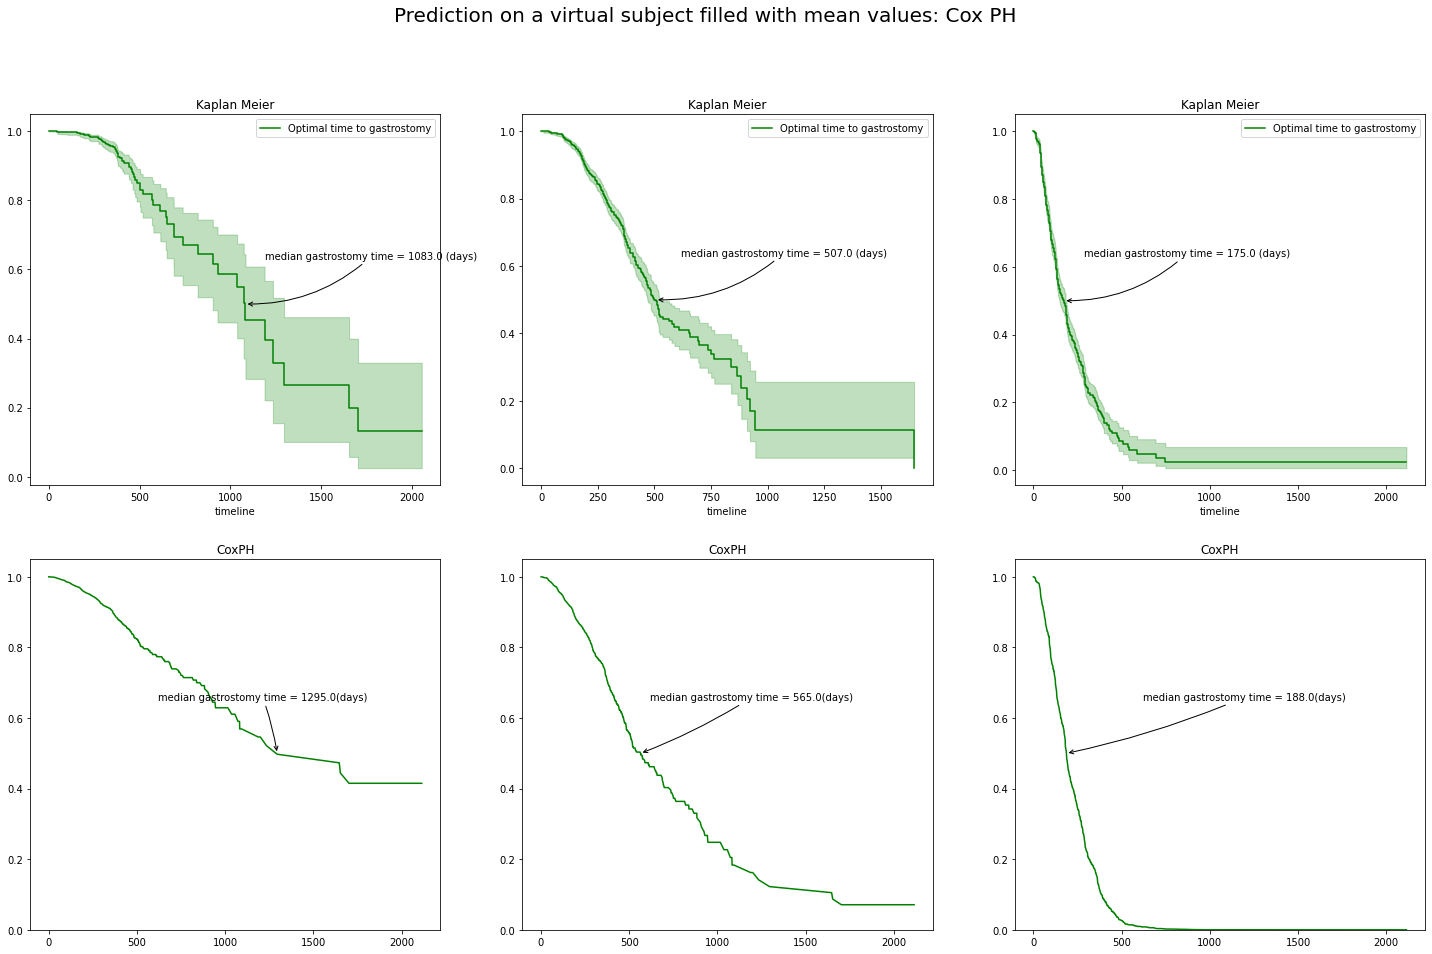

In [55]:
plt.figure(figsize=(25, 15))

plt.subplot(231)
OPT = kmf.fit(X_cph_slow["time_opt"], X_cph_slow["status_opt"], label='Optimal time to gastrostomy')
ax_kmf = OPT.plot(color='green')
plt.title("Kaplan Meier")
plt.annotate("median gastrostomy time = "+str(OPT.median_survival_time_)+" (days)", xy=(float(OPT.median_survival_time_), 0.5)
                , xytext=(float(OPT.median_survival_time_)+110, 0.63), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.2"))

plt.subplot(232)
OPT = kmf.fit(X_cph_medium["time_opt"], X_cph_medium["status_opt"], label='Optimal time to gastrostomy')
ax_kmf = OPT.plot(color='green')
plt.title("Kaplan Meier")
plt.annotate("median gastrostomy time = "+str(OPT.median_survival_time_)+" (days)", xy=(float(OPT.median_survival_time_), 0.5)
                , xytext=(float(OPT.median_survival_time_)+110, 0.63), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.2"))

plt.subplot(233)
OPT = kmf.fit(X_cph_fast["time_opt"], X_cph_fast["status_opt"], label='Optimal time to gastrostomy')
ax_kmf = OPT.plot(color='green')
plt.title("Kaplan Meier")
plt.annotate("median gastrostomy time = "+str(OPT.median_survival_time_)+" (days)", xy=(float(OPT.median_survival_time_), 0.5)
                , xytext=(float(OPT.median_survival_time_)+110, 0.63), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.2"))

plt.subplot(234)
plt.plot(result_cph_slow.index, result_cph_slow, marker='None', color='green')
plt.title("CoxPH")
plt.ylim([0,1.05])
plt.annotate("median gastrostomy time = "+ str(cph.predict_median(VIRT_cph_slow)) +"(days)", xy=(cph.predict_median(VIRT_cph_slow), 0.5)
                , xytext=(510+110, 0.65), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.05"))

plt.subplot(235)
plt.plot(result_cph_medium.index, result_cph_medium, marker='None', color='green')
plt.title("CoxPH")
plt.ylim([0,1.05])
plt.annotate("median gastrostomy time = "+ str(cph.predict_median(VIRT_cph_medium)) +"(days)", xy=(cph.predict_median(VIRT_cph_medium), 0.5)
                , xytext=(510+110, 0.65), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.05"))

plt.subplot(236)
plt.plot(result_cph_fast.index, result_cph_fast, marker='None', color='green')
plt.title("CoxPH")
plt.ylim([0,1.05])
plt.annotate("median gastrostomy time = "+ str(cph.predict_median(VIRT_cph_fast)) +"(days)", xy=(cph.predict_median(VIRT_cph_fast), 0.5)
                , xytext=(510+110, 0.65), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.05"))

plt.suptitle('Prediction on a virtual subject filled with mean values: Cox PH', fontsize=20)
plt.show()

## Random Survival Forest

In [71]:
!pip install --upgrade pip
!pip uninstall --yes --quiet osqp
!pip install -U scikit-survival

     |████████████████████████████████| 2.4 MB 6.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 2.3 MB 42.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 212 kB 27.9 MB/s 
  Created wheel for scikit-survival: filename=scikit_survival-0.14.0-cp37-cp37m-linux_x86_64.whl size=4061884 sha256=d31fc862e02eae85280073bc90ca527438f1078d4ad85213fcd41cabef3cf2eb
  Stored in directory: /root/.cache/pip/wheels/a2/3e/97/3722ba215d3dfe5429c1a7e4f24f535a3f46004fb29a16d505
Successfully built scikit-survival


In [73]:
from sksurv.ensemble import RandomSurvivalForest

dic = {1:True, 0:False}

df_train_rsf = df_train.iloc[:, -2:][['status_opt', 'time_opt']]
df_train_rsf = df_train_rsf.replace({'status_opt':dic})

arr_1 = list(tuple(x) for x in df_train_rsf.to_records(index=False))
dt=np.dtype('bool, float')
y_train_rsf = np.array(arr_1, dtype=dt)
y_train_rsf.dtype.names=['cens', 'time']

rsf = RandomSurvivalForest(n_estimators=100,
                           min_samples_split=8,
                           min_samples_leaf=8,
                           max_features="auto",
                           n_jobs=-1,
                           random_state=20)
rsf.fit(df_train.iloc[:,:-2], y_train_rsf)

RandomSurvivalForest(bootstrap=True, max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None, min_samples_leaf=8,
                     min_samples_split=8, min_weight_fraction_leaf=0.0,
                     n_estimators=100, n_jobs=-1, oob_score=False,
                     random_state=20, verbose=0, warm_start=False)

In [102]:
def predict_rsf_median(data):
  result = rsf.predict_survival_function(data.to_numpy().reshape(1, -1), return_array = True)
  result = np.squeeze(result)
  time_result = pd.DataFrame({'time' : rsf.event_times_, 'p' : result })

  if time_result[time_result['p'] <= 0.5].count()['time'] == 0:
    median = np.inf
  else:
    median = time_result[time_result['p'] <= 0.5].iloc[0,0]

  return median

In [103]:
rsf_median_list = []
for i in range(df_train.shape[0]):
  rsf_median_list.append(predict_rsf_median(df_train.iloc[i,:-2]))

rsf_median_list

[inf,
 inf,
 154.0,
 508.0,
 187.0,
 inf,
 inf,
 286.0,
 444.0,
 280.0,
 765.0,
 119.0,
 362.0,
 137.0,
 736.0,
 589.0,
 261.0,
 240.0,
 inf,
 485.0,
 946.0,
 335.0,
 1188.0,
 inf,
 426.0,
 1653.0,
 inf,
 1188.0,
 440.0,
 884.0,
 511.0,
 649.0,
 353.0,
 336.0,
 384.0,
 inf,
 565.0,
 258.0,
 443.0,
 407.0,
 inf,
 inf,
 1083.0,
 129.0,
 371.0,
 inf,
 inf,
 inf,
 74.0,
 349.0,
 348.0,
 1073.0,
 48.0,
 414.0,
 361.0,
 188.0,
 267.0,
 371.0,
 253.0,
 867.0,
 78.0,
 515.0,
 inf,
 483.0,
 365.0,
 658.0,
 568.0,
 322.0,
 240.0,
 inf,
 inf,
 inf,
 inf,
 inf,
 248.0,
 260.0,
 inf,
 128.0,
 inf,
 56.0,
 inf,
 380.0,
 144.0,
 280.0,
 inf,
 235.0,
 1653.0,
 226.0,
 inf,
 694.0,
 inf,
 470.0,
 589.0,
 189.0,
 444.0,
 381.0,
 inf,
 428.0,
 751.0,
 292.0,
 288.0,
 inf,
 inf,
 inf,
 1653.0,
 1702.0,
 inf,
 576.0,
 737.0,
 293.0,
 inf,
 inf,
 78.0,
 91.0,
 946.0,
 inf,
 inf,
 1083.0,
 290.0,
 537.0,
 67.0,
 inf,
 350.0,
 461.0,
 inf,
 inf,
 1653.0,
 280.0,
 294.0,
 288.0,
 inf,
 inf,
 313.0,
 inf,
 inf,

In [119]:
rsf_median = pd.concat([X_full['SubjectID'], pd.Series(rsf_median_list)], axis=1)
rsf_median

,SubjectID,0
0,329.0,inf
1,348.0,inf
2,708.0,154.0
3,902.0,508.0
4,1736.0,187.0
...,...,...
3394,998756.0,248.0
3395,999166.0,820.0
3396,999823.0,148.0
3397,999880.0,946.0


In [120]:
print('There are ' + str(rsf_median.replace([np.inf,-np.inf], np.nan).isnull().sum(axis = 0).iloc[1]) + ' inf values in rsf_median')

There are 915 inf values in rsf_median


In [121]:
rsf_median_max = rsf_median.replace([np.inf,-np.inf], np.nan).dropna(subset=[0],how='all')[0].max()
rsf_inf = rsf_median_max + 200
rsf_median = rsf_median.replace([np.inf,-np.inf], rsf_inf)

In [123]:
rsf_median_max

1702.0

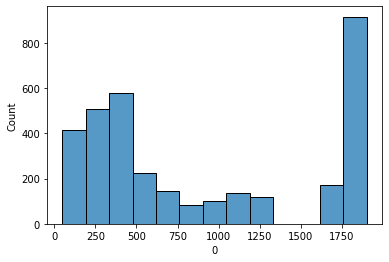

In [122]:
sns.histplot(x = rsf_median[0])

In [124]:
rsf_median.describe()

,SubjectID,0
count,3399.000000,3399.000000
mean,506781.466019,921.775228
std,293087.479128,705.303542
min,329.000000,48.000000
25%,253969.500000,304.000000
50%,514072.000000,589.000000
75%,765723.500000,1902.000000
max,999990.000000,1902.000000


In [125]:
rsf_slow_list = list(rsf_median[rsf_median[0] >= 1902]['SubjectID'])
rsf_medium_list = list(rsf_median[(rsf_median[0] >= 304) & (rsf_median[0] < 1902)]['SubjectID'])
rsf_fast_list = list(rsf_median[rsf_median[0]  < 304]['SubjectID'])
X_rsf_slow = X_full[X_full['SubjectID'].isin(rsf_slow_list)]
X_rsf_medium = X_full[X_full['SubjectID'].isin(rsf_medium_list)]
X_rsf_fast = X_full[X_full['SubjectID'].isin(rsf_fast_list)]

In [127]:
VIRT_rsf_slow = pd.DataFrame(X_rsf_slow.mean()).transpose().iloc[:, 1:-2]
VIRT_rsf_medium = pd.DataFrame(X_rsf_medium.mean()).transpose().iloc[:, 1:-2]
VIRT_rsf_fast = pd.DataFrame(X_rsf_fast.mean()).transpose().iloc[:, 1:-2]

In [131]:
predict_rsf_median(VIRT_rsf_fast)

175.0

In [128]:
result_rsf_slow = rsf.predict_survival_function(VIRT_rsf_slow, return_array=True)
result_rsf_medium = rsf.predict_survival_function(VIRT_rsf_medium, return_array=True)
result_rsf_fast = rsf.predict_survival_function(VIRT_rsf_fast, return_array=True)

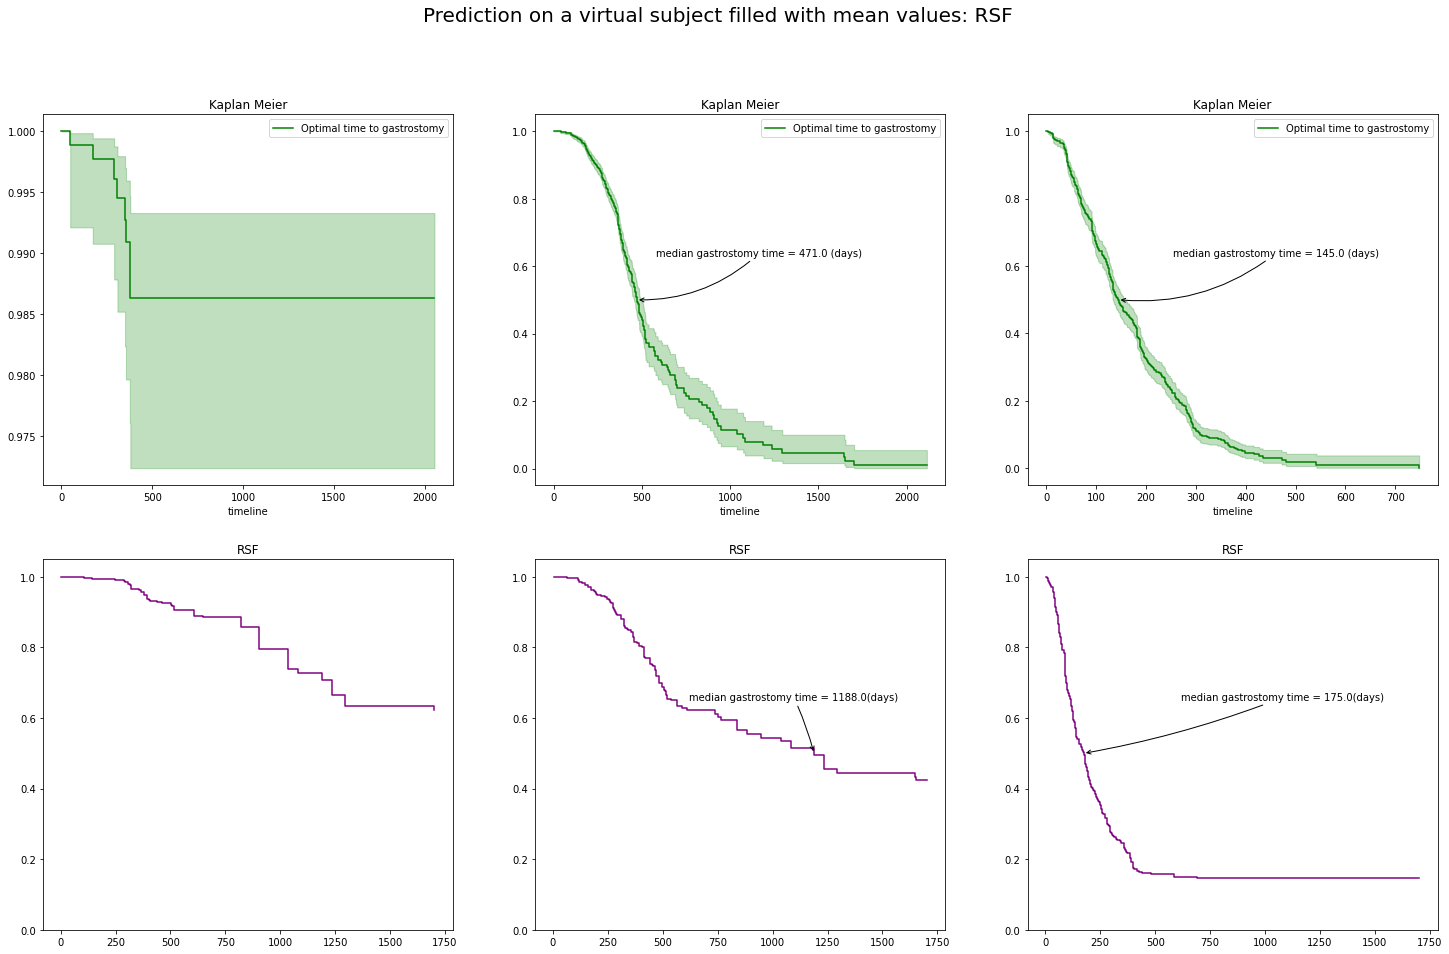

In [135]:
plt.figure(figsize=(25, 15))

plt.subplot(231)
OPT = kmf.fit(X_rsf_slow["time_opt"], X_rsf_slow["status_opt"], label='Optimal time to gastrostomy')
ax_kmf = OPT.plot(color='green')
plt.title("Kaplan Meier")


plt.subplot(232)
OPT = kmf.fit(X_rsf_medium["time_opt"], X_rsf_medium["status_opt"], label='Optimal time to gastrostomy')
ax_kmf = OPT.plot(color='green')
plt.title("Kaplan Meier")
plt.annotate("median gastrostomy time = "+str(OPT.median_survival_time_)+" (days)", xy=(float(OPT.median_survival_time_), 0.5)
                , xytext=(float(OPT.median_survival_time_)+110, 0.63), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.2"))

plt.subplot(233)
OPT = kmf.fit(X_rsf_fast["time_opt"], X_rsf_fast["status_opt"], label='Optimal time to gastrostomy')
ax_kmf = OPT.plot(color='green')
plt.title("Kaplan Meier")
plt.annotate("median gastrostomy time = "+str(OPT.median_survival_time_)+" (days)", xy=(float(OPT.median_survival_time_), 0.5)
                , xytext=(float(OPT.median_survival_time_)+110, 0.63), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.2"))

plt.subplot(234)
for i, s in enumerate(result_rsf_slow):
    plt.step(rsf.event_times_, s, where="post", color='purple')
plt.ylim([0,1.05])
plt.title('RSF')

plt.subplot(235)
for i, s in enumerate(result_rsf_medium):
    plt.step(rsf.event_times_, s, where="post", color='purple')
plt.ylim([0,1.05])
plt.annotate("median gastrostomy time = "+ str(predict_rsf_median(VIRT_rsf_medium)) +"(days)", xy=(predict_rsf_median(VIRT_rsf_medium), 0.5)
                , xytext=(510+110, 0.65), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.05"))
plt.title('RSF')

plt.subplot(236)
for i, s in enumerate(result_rsf_fast):
    plt.step(rsf.event_times_, s, where="post", color='purple')
plt.ylim([0,1.05])
plt.annotate("median gastrostomy time = "+ str(predict_rsf_median(VIRT_rsf_fast)) +"(days)", xy=(predict_rsf_median(VIRT_rsf_fast), 0.5)
                , xytext=(510+110, 0.65), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.05"))
plt.title('RSF')

plt.suptitle('Prediction on a virtual subject filled with mean values: RSF', fontsize=20)
plt.show()

## Accelerated Failure Time model

In [56]:
from lifelines import WeibullAFTFitter
aft = WeibullAFTFitter()
aft.fit(df_train, 'time_opt', 'status_opt', ancillary=False)

<lifelines.WeibullAFTFitter: fitted with 3399 total observations, 2234 right-censored observations>

In [57]:
aft_median = pd.concat([X_full['SubjectID'],aft.predict_median(df_train)], axis=1)
aft_median

,SubjectID,0
0,329.0,2408.428568
1,348.0,888.096383
2,708.0,425.943391
3,902.0,462.173855
4,1736.0,198.168693
...,...,...
3394,998756.0,220.363875
3395,999166.0,561.509377
3396,999823.0,319.468797
3397,999880.0,3693.604784


In [58]:
print('There are ' + str(aft_median.replace([np.inf,-np.inf], np.nan).isnull().sum(axis = 0).iloc[1]) + ' inf values in aft_median')

There are 0 inf values in aft_median


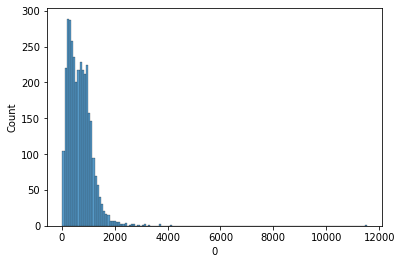

In [60]:
sns.histplot(x = aft_median[0])

In [61]:
aft_median.describe()

,SubjectID,0
count,3399.000000,3399.000000
mean,506781.466019,683.561919
std,293087.479128,475.700829
min,329.000000,23.413911
25%,253969.500000,330.075146
50%,514072.000000,633.224552
75%,765723.500000,939.540021
max,999990.000000,11532.411228


In [62]:
aft_slow_list = list(aft_median[aft_median[0] >= 939.540021]['SubjectID'])
aft_medium_list = list(aft_median[(aft_median[0] >= 330.075146) & (cph_median[0.5] < 939.540021)]['SubjectID'])
aft_fast_list = list(aft_median[aft_median[0]  < 330.075146]['SubjectID'])
X_aft_slow = X_full[X_full['SubjectID'].isin(aft_slow_list)]
X_aft_medium = X_full[X_full['SubjectID'].isin(aft_medium_list)]
X_aft_fast = X_full[X_full['SubjectID'].isin(aft_fast_list)]

In [63]:
VIRT_aft_slow = pd.DataFrame(X_aft_slow.mean()).transpose().iloc[:, 1:-2]
VIRT_aft_medium = pd.DataFrame(X_aft_medium.mean()).transpose().iloc[:, 1:-2]
VIRT_aft_fast = pd.DataFrame(X_aft_fast.mean()).transpose().iloc[:, 1:-2]

In [64]:
result_aft_slow = aft.predict_survival_function(VIRT_aft_slow)
result_aft_medium = aft.predict_survival_function(VIRT_aft_medium)
result_aft_fast = aft.predict_survival_function(VIRT_aft_fast)

In [69]:
aft.predict_median(VIRT_aft_slow)[0]

1221.8188193748563

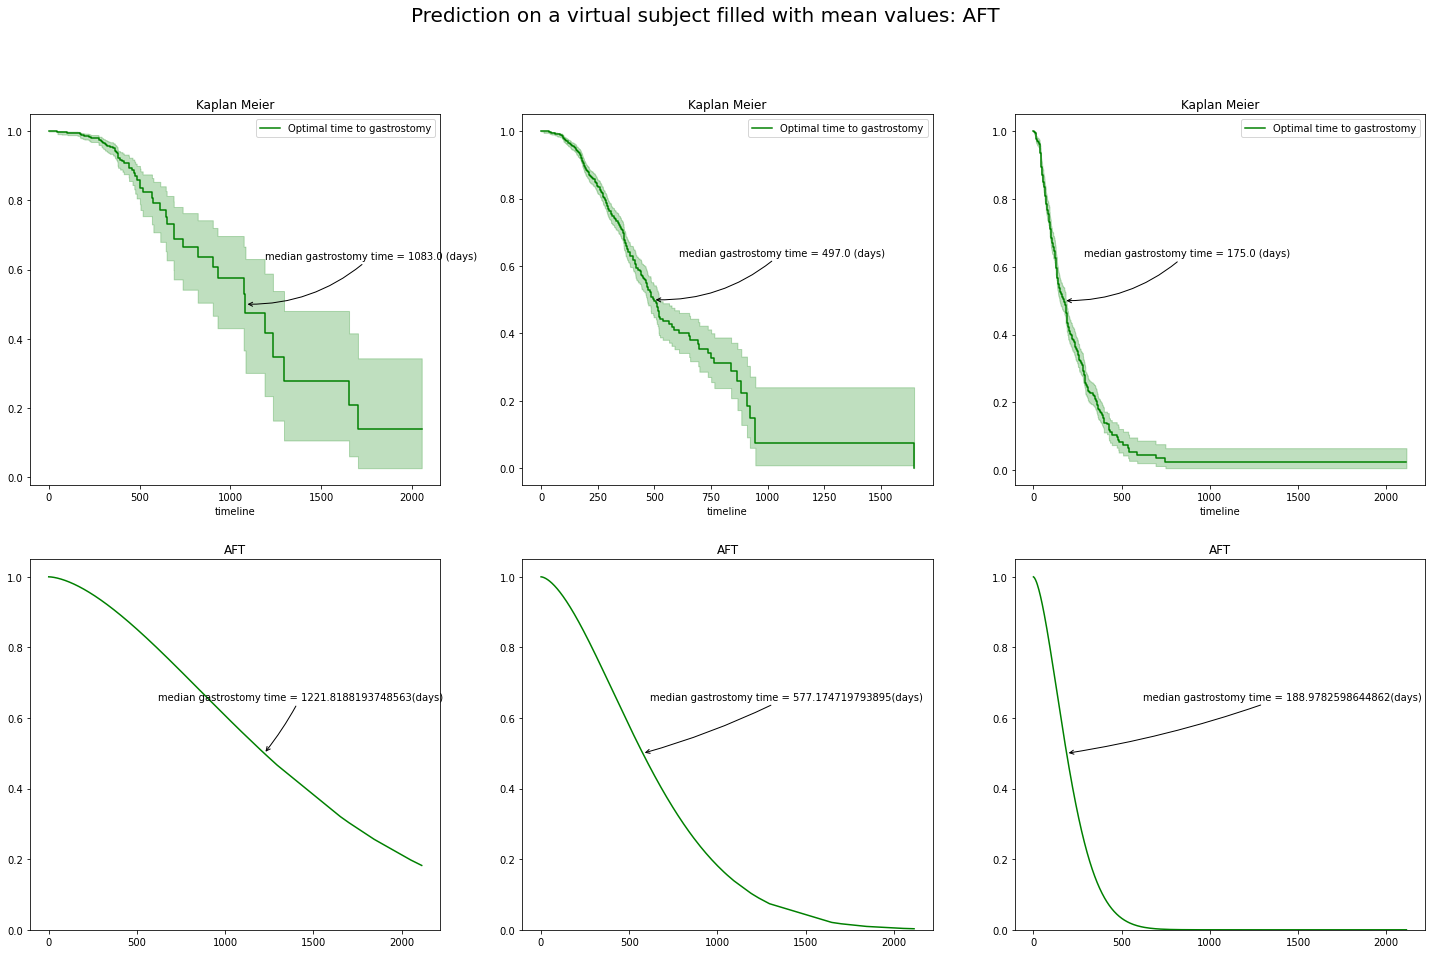

In [70]:
plt.figure(figsize=(25, 15))

plt.subplot(231)
OPT = kmf.fit(X_aft_slow["time_opt"], X_aft_slow["status_opt"], label='Optimal time to gastrostomy')
ax_kmf = OPT.plot(color='green')
plt.title("Kaplan Meier")
plt.annotate("median gastrostomy time = "+str(OPT.median_survival_time_)+" (days)", xy=(float(OPT.median_survival_time_), 0.5)
                , xytext=(float(OPT.median_survival_time_)+110, 0.63), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.2"))

plt.subplot(232)
OPT = kmf.fit(X_aft_medium["time_opt"], X_aft_medium["status_opt"], label='Optimal time to gastrostomy')
ax_kmf = OPT.plot(color='green')
plt.title("Kaplan Meier")
plt.annotate("median gastrostomy time = "+str(OPT.median_survival_time_)+" (days)", xy=(float(OPT.median_survival_time_), 0.5)
                , xytext=(float(OPT.median_survival_time_)+110, 0.63), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.2"))

plt.subplot(233)
OPT = kmf.fit(X_aft_fast["time_opt"], X_aft_fast["status_opt"], label='Optimal time to gastrostomy')
ax_kmf = OPT.plot(color='green')
plt.title("Kaplan Meier")
plt.annotate("median gastrostomy time = "+str(OPT.median_survival_time_)+" (days)", xy=(float(OPT.median_survival_time_), 0.5)
                , xytext=(float(OPT.median_survival_time_)+110, 0.63), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.2"))

plt.subplot(234)
plt.plot(result_aft_slow.index, result_aft_slow[0], marker='None', color='green')
plt.title("AFT")
plt.ylim([0,1.05])
plt.annotate("median gastrostomy time = "+ str(aft.predict_median(VIRT_aft_slow)[0]) +"(days)", xy=(aft.predict_median(VIRT_aft_slow)[0], 0.5)
                , xytext=(510+110, 0.65), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.05"))

plt.subplot(235)
plt.plot(result_aft_medium.index, result_aft_medium[0], marker='None', color='green')
plt.title("AFT")
plt.ylim([0,1.05])
plt.annotate("median gastrostomy time = "+ str(aft.predict_median(VIRT_aft_medium)[0]) +"(days)", xy=(aft.predict_median(VIRT_aft_medium)[0], 0.5)
                , xytext=(510+110, 0.65), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.05"))

plt.subplot(236)
plt.plot(result_aft_fast.index, result_aft_fast[0], marker='None', color='green')
plt.title("AFT")
plt.ylim([0,1.05])
plt.annotate("median gastrostomy time = "+ str(aft.predict_median(VIRT_aft_fast)[0]) +"(days)", xy=(aft.predict_median(VIRT_aft_fast)[0], 0.5)
                , xytext=(510+110, 0.65), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.05"))

plt.suptitle('Prediction on a virtual subject filled with mean values: AFT', fontsize=20)
plt.show()